## 9) Output visual display of the lane boundaries (testing out pipeline)

../test_images/test1.jpg


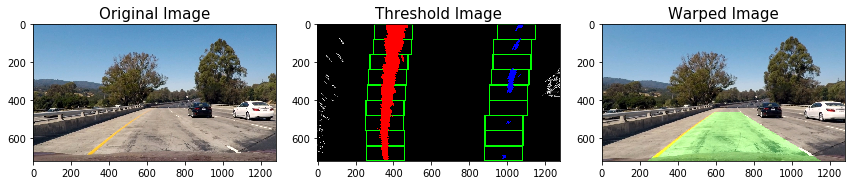

../test_images/test2.jpg


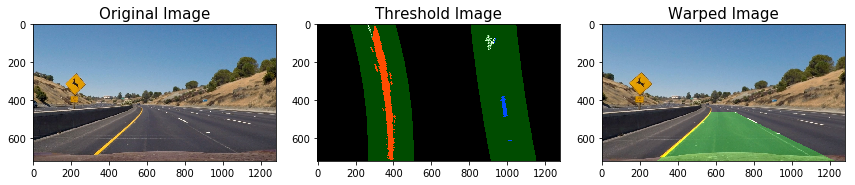

../test_images/test3.jpg


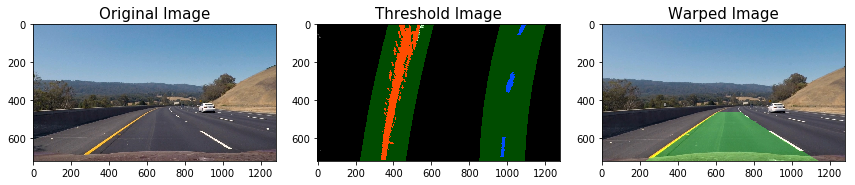

../test_images/test4.jpg


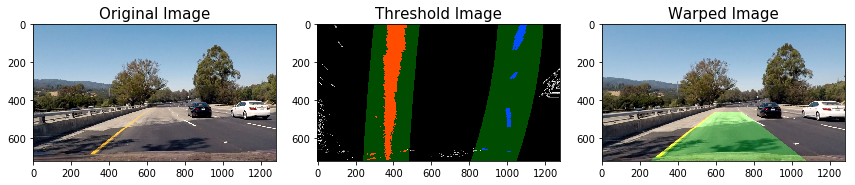

../test_images/test5.jpg


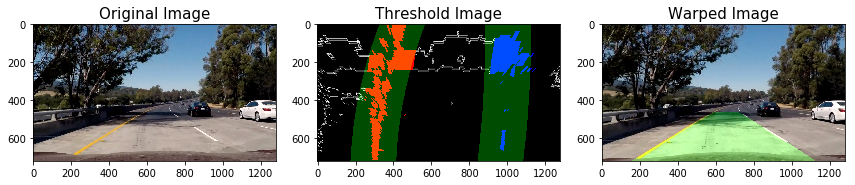

../test_images/test6.jpg


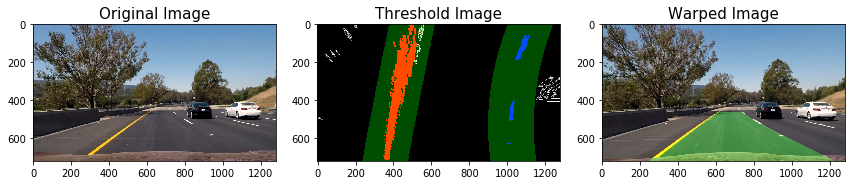

In [4]:
%run 'imports.py'
%run 'testbed_misc.py'

images = glob.glob('../test_images/test*.jpg')
for img_idx, fname in enumerate(images):
    print(fname)
    
    img = mpimg.imread(fname)
    img_undist = cal_undistort(img)
    threshold_img = threshold_pipeline(img_undist, Settings.thresholds, ksize=23, debug=False)
    img_warp, M, Minv = warp_image(threshold_img)

    ## Visualize warped images and perspective transform
    #_, _, ax3 = visualize_images(img, threshold_img, img_warp)
    #ax3.add_patch(patches.Polygon(xy=[Settings.dst[0],Settings.dst[1],\
        #Settings.dst[3],Settings.dst[2]], fill=False, edgecolor='r'))

    if img_idx == 0:
        lane_lines_image, left_fitx, right_fitx, ploty, init_left_fit, init_right_fit, x_pts, y_pts = \
            sliding_window_line_search(img_warp, 100, Settings.nwindows, 50)
    else:
        lane_lines_image, left_fitx, right_fitx, ploty, left_fit, right_fit, x_pts, y_pts = \
            bounded_window_line_search(img_warp, 120, init_left_fit, init_right_fit)

    ## Visualize detected lane lines on warped image
    #_, _, ax3 = visualize_images(img, img_warp, lane_lines_image)
    #ax3.plot(left_fitx, ploty, color='yellow')
    #ax3.plot(right_fitx, ploty, color='yellow')
    
    warp_zero = np.zeros_like(img_warp).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    new_warp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    final_image = cv2.addWeighted(img_undist, 1, new_warp, 0.3, 0)
    
    # Visualize detected lane lines on undistorted image
    _, _, _ = visualize_images(img, lane_lines_image, final_image)
    plt.show()


## 10a) Create function for image processing pipeline.

In [12]:
%run 'imports.py'
%run 'testbed_misc.py'


def process_image(img, return_ll_image=False):
    
    img_undist = cal_undistort(img)
    threshold_img = threshold_pipeline(img_undist, Settings.thresholds, ksize=23, debug=False)
    threshold_img = threshold_img * 255
    img_warp, M, Minv = warp_image(threshold_img)

    ## Visualize warped images and perspective transform
    #_, _, ax3 = visualize_images(img, threshold_img, img_warp)
    #ax3.add_patch(patches.Polygon(xy=[dst[0],dst[1],dst[3],dst[2]], fill=False, edgecolor='r'))

    if not left_line.detected or not right_line.detected:
        lane_lines_image, left_fitx, right_fitx, ploty, left_fit, right_fit, x_pts, y_pts = \
            sliding_window_line_search(img_warp, 100, Settings.nwindows, 50)
    else:
        lane_lines_image, left_fitx, right_fitx, ploty, left_fit, right_fit, x_pts, y_pts = \
            bounded_window_line_search(img_warp, 120, left_line.best_fit, right_line.best_fit)

    # Check if lines are parallel enough
    fit_diff = abs(left_fit - right_fit)
    if (fit_diff[0] > Settings.max_para_diffs[0] or fit_diff[1] > Settings.max_para_diffs[1]):
        left_line.is_parallel = False
        right_line.is_parallel = False
    else:
        left_line.is_parallel = True
        right_line.is_parallel = True
        
    # Update lines
    left_line.update(threshold_img.shape, left_fit, left_fitx, x_pts['left'], y_pts['left'], ploty)
    right_line.update(threshold_img.shape, right_fit, right_fitx, x_pts['right'], y_pts['right'], ploty)
    
    # Update curve radius and distance from center
    curve_radius = (left_line.curve_rad + left_line.curve_rad) / 2
    pos = threshold_img.shape[1] / 2
    center_pos = (left_line.x_intercept + right_line.x_intercept) / 2
    center_dist = (pos - center_pos) * Line.xm_per_pix
    
    left_line.plot_line(lane_lines_image, left_fitx, ploty, (0, 255, 255))
    left_line.plot_line(lane_lines_image, left_line.best_fitx, ploty)
    left_line.plot_line(lane_lines_image, right_fitx, ploty, (0, 255, 255))
    right_line.plot_line(lane_lines_image, right_line.best_fitx, ploty)
            
    ## Visualize detected lane lines on warped image
    #_, _, ax3 = visualize_images(img, img_warp, lane_lines_image)
    #ax3.plot(left_fitx, ploty, color='yellow')
    #ax3.plot(right_fitx, ploty, color='yellow')
    
    final_image = draw_polyline_on_image(img_warp, img_undist, Minv, left_line, right_line, ploty)
    
    ## Visualize detected lane lines on undistorted image
    #_, _, _ = visualize_images(img, lane_lines_image, final_image)
    
    show_debug_radar_view = False
    if show_debug_radar_view:
        radar_size = tuple([x//5 for x in lane_lines_image.shape[:2][::-1]])
        radar_image = cv2.resize(lane_lines_image, radar_size)
        x_offset = 50
        y_offset = 50
        final_image[y_offset:y_offset+radar_image.shape[0], x_offset:x_offset+radar_image.shape[1]] = radar_image
        
    show_debug_view = False
    if show_debug_view:
        debug_img = np.zeros((720,1280,3), dtype=np.uint8)
        debug_img[0:360,0:640,:] = cv2.resize(final_image,(640,360))
        
        threshold_img = np.dstack((threshold_img*255, threshold_img*255, threshold_img*255))
        resized_img_bin = cv2.resize(threshold_img,(640,360))
        debug_img[0:360,640:1280, :] = resized_img_bin
        
        debug_img[360:720,640:1280,:] = cv2.resize(lane_lines_image,(640,360))
        
        color_ok = (200,255,155)
        color_bad = (255,155,155)
        font = cv2.FONT_HERSHEY_DUPLEX
        if left_fit is not None:
            text = 'This fit L: ' + ' {:0.6f}'.format(left_fit[0]) + \
                                    ' {:0.6f}'.format(left_fit[1]) + \
                                    ' {:0.6f}'.format(left_fit[2])
        else:
            text = 'This fit L: None'
        cv2.putText(debug_img, text, (40,380), font, .5, color_ok, 1, cv2.LINE_AA)
        if right_fit is not None:
            text = 'This fit R: ' + ' {:0.6f}'.format(right_fit[0]) + \
                                    ' {:0.6f}'.format(right_fit[1]) + \
                                    ' {:0.6f}'.format(right_fit[2])
        else:
            text = 'This fit R: None'
        cv2.putText(debug_img, text, (40,400), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit L: ' + ' {:0.6f}'.format(left_line.best_fit[0]) + \
                                ' {:0.6f}'.format(left_line.best_fit[1]) + \
                                ' {:0.6f}'.format(left_line.best_fit[2])
        cv2.putText(debug_img, text, (40,440), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit R: ' + ' {:0.6f}'.format(right_line.best_fit[0]) + \
                                ' {:0.6f}'.format(right_line.best_fit[1]) + \
                                ' {:0.6f}'.format(right_line.best_fit[2])
        cv2.putText(debug_img, text, (40,460), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Diffs L: ' + ' {:0.6f}'.format(left_line.diffs[0]) + \
                             ' {:0.6f}'.format(left_line.diffs[1]) + \
                             ' {:0.6f}'.format(left_line.diffs[2])
        if left_line.diffs[0] > Settings.max_diffs[0] or \
           left_line.diffs[1] > Settings.max_diffs[1] or \
           left_line.diffs[2] > Settings.max_diffs[2]:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,500), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Diffs R: ' + ' {:0.6f}'.format(right_line.diffs[0]) + \
                             ' {:0.6f}'.format(right_line.diffs[1]) + \
                             ' {:0.6f}'.format(right_line.diffs[2])
        if right_line.diffs[0] > Settings.max_diffs[0] or \
           right_line.diffs[1] > Settings.max_diffs[1] or \
           right_line.diffs[2] > Settings.max_diffs[2]:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(debug_img, text, (40,520), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Good fit count L:' + str(len(left_line.recent_fits))
        cv2.putText(debug_img, text, (40,560), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Good fit count R:' + str(len(right_line.recent_fits))
        cv2.putText(debug_img, text, (40,580), font, .5, color_ok, 1, cv2.LINE_AA)
        
        text = 'Curve Radius: ' + str(curve_radius) + 'm'
        cv2.putText(debug_img, text, (40,620), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Distance from Center: ' + str(center_dist)
        cv2.putText(debug_img, text, (40,640), font, .5, color_ok, 1, cv2.LINE_AA)
        
        if left_line.is_parallel and right_line.is_parallel:
            para_color = color_ok
        else:
            para_color = color_bad
        text = 'Parallel Lines : ' + str(left_line.is_parallel and right_line.is_parallel)
        cv2.putText(diag_img, text, (40,660), font, .5, para_color, 1, cv2.LINE_AA)
        
        if left_line.detected:
            detected_color = color_ok
        else:
            detected_color = color_bad
        text = 'Detected Line L : ' + str(left_line.detected)
        cv2.putText(diag_img, text, (40,680), font, .5, detected_color, 1, cv2.LINE_AA)
        
        if right_line.detected:
            detected_color = color_ok
        else:
            detected_color = color_bad
        text = 'Detected Line R : ' + str(right_line.detected)
        cv2.putText(diag_img, text, (40,700), font, .5, detected_color, 1, cv2.LINE_AA)
        
        output_image = debug_img
    else:
        font = cv2.FONT_HERSHEY_DUPLEX
        text = 'Curve Radius: ' + '{:04.4f}'.format(curve_radius) + 'm'
        cv2.putText(final_image, text, (40,70), font, 1.5, (255,255,255), 1, cv2.LINE_AA)
        text = 'Distance from Center: ' + '{:04.4f}'.format(center_dist) + 'm'
        cv2.putText(final_image, text, (40,120), font, 1.5, (255,255,255), 1, cv2.LINE_AA)
        output_image = final_image
    
    if return_ll_image:
        return output_image, lane_lines_image
    else:
        return output_image


## 10b) Output visual display after image processing

../test_images/test1.jpg


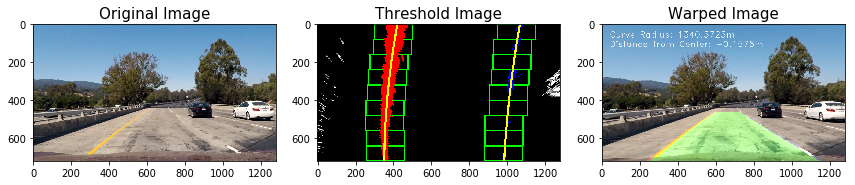

../test_images/test2.jpg


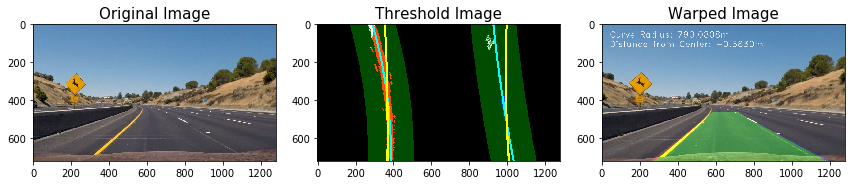

../test_images/test3.jpg


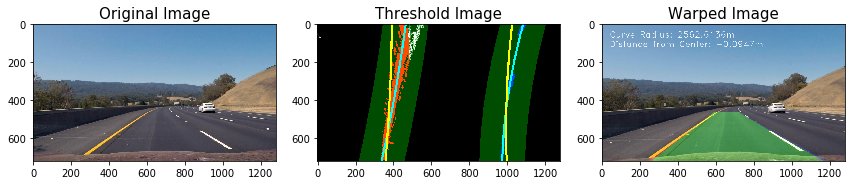

../test_images/test4.jpg


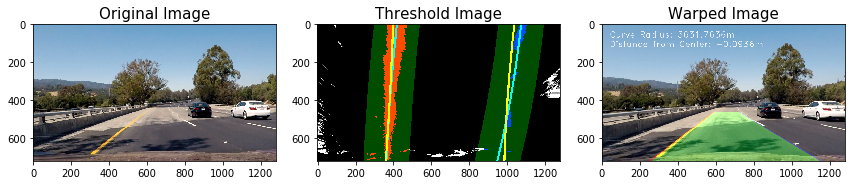

../test_images/test5.jpg


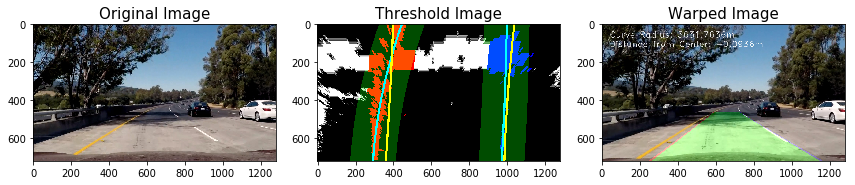

../test_images/test6.jpg


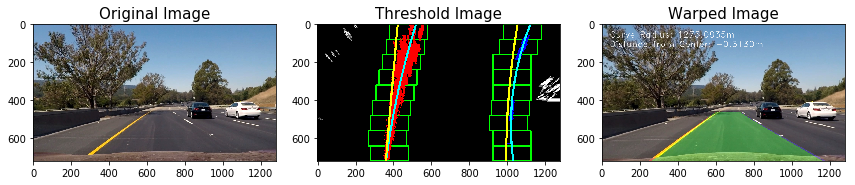

In [13]:
%run 'imports.py'
%run 'testbed_misc.py'

images = glob.glob('../test_images/test*.jpg')
path = '../output_images/'

left_line = Line()
right_line = Line()
for img_idx, fname in enumerate(images):
    filename = fname.split('/')[-1]
    print(fname)
    #print(path+fname.split('/')[-1])
    
    img = mpimg.imread(fname)
    new_img, ll_image = process_image(img, True)
    
    # Visualize detected lane lines on undistorted image
    _, _, _ = visualize_images(img, ll_image, new_img)
    #cv2.imwrite(path+filename, new_img)
    
    plt.show()

## 10c) Apply image processing function to video

In [14]:
%run 'imports.py'
%run 'testbed_misc.py'
from moviepy.editor import VideoFileClip

left_line = Line()
right_line = Line()

output_video = './output_processed.mp4'
input_video = '../project_video.mp4'

clip1 = VideoFileClip(input_video)
video_clip = clip1.fl_image(process_image)
video_clip.write_videofile(output_video, audio=False)


[MoviePy] >>>> Building video ./output_processed.mp4
[MoviePy] Writing video ./output_processed.mp4


100%|█████████▉| 1260/1261 [11:15<00:00,  1.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_processed.mp4 

